In [1]:
# Paris Housing Prices Kaggle competition
# Collaborators: Aurian Ghaemmaghami and Nicola Talley
# Python version 3.7.1
# Start Date: 5/05/2023
# Latest Edit: 5/09/2023 - Aurian: Started preliminary EDA of all features. Correlation matrix to observe multicollinearity and importance to target

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from yellowbrick.regressor import AlphaSelection
from platform import python_version

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

print(python_version())

3.7.1


In [2]:
# Read in dataset
df = pd.read_csv('train.csv')
test_final = pd.read_csv('test.csv')

# Create copies to do manipulations
data = df.copy()
test_data = test_final.copy()
data.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22730 entries, 0 to 22729
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 22730 non-null  int64  
 1   squareMeters       22730 non-null  int64  
 2   numberOfRooms      22730 non-null  int64  
 3   hasYard            22730 non-null  int64  
 4   hasPool            22730 non-null  int64  
 5   floors             22730 non-null  int64  
 6   cityCode           22730 non-null  int64  
 7   cityPartRange      22730 non-null  int64  
 8   numPrevOwners      22730 non-null  int64  
 9   made               22730 non-null  int64  
 10  isNewBuilt         22730 non-null  int64  
 11  hasStormProtector  22730 non-null  int64  
 12  basement           22730 non-null  int64  
 13  attic              22730 non-null  int64  
 14  garage             22730 non-null  int64  
 15  hasStorageRoom     22730 non-null  int64  
 16  hasGuestRoom       227

In [4]:
data.shape

(22730, 18)

In [5]:
# Check out summary statistics
data.describe()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,22730.000000,2.273000e+04,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,2.273000e+04
mean,11364.500000,4.658622e+04,48.241091,0.475891,0.452750,47.305983,50013.795996,5.585042,5.620766,2008.005059,0.467972,0.460009,5283.646634,5067.981698,530.469644,0.461681,5.153058,4.634457e+06
std,6561.730145,4.952124e+04,28.226428,0.499429,0.497773,47.777207,30006.637729,2.739533,2.713026,118.826777,0.498984,0.498409,3047.084412,3097.347939,274.840604,0.498540,3.055246,2.925163e+06
min,0.000000,8.900000e+01,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04
25%,5682.250000,2.039275e+04,25.000000,0.000000,0.000000,25.000000,22936.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2977.250000,2599.000000,297.000000,0.000000,3.000000,2.041739e+06
50%,11364.500000,4.448400e+04,47.000000,0.000000,0.000000,45.000000,50414.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,4977.000000,515.000000,0.000000,5.000000,4.450823e+06
75%,17046.750000,7.154700e+04,75.000000,1.000000,1.000000,69.000000,76291.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7746.000000,7652.000000,767.000000,1.000000,8.000000,7.159920e+06
max,22729.000000,6.071330e+06,100.000000,1.000000,1.000000,6000.000000,491100.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000428e+07


# EDA  
We have 17 numeric features non-inclusive of our "ID" field which will be unnecessary for our analysis.  
Below we will begin an individualistic, investigative approach to our feature pool.

#### squareMeters
Need to check data details of this source to see how these meters are measured and squared.  
May circle back and conduct a re-engineered approach of this variable for non-squared meters.  

##### results
There was an apparent outlier that broke our visual assumption w.r.t our IQR bounds of the boxplot.  
The outlier was truncating our distribution showing apparent evidence of a highly influential point with extreme leverage.  
Due to these findings, there is enough evidence to suggest the removal of this outlier pending a Grubbs' outlier statistical test.

C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


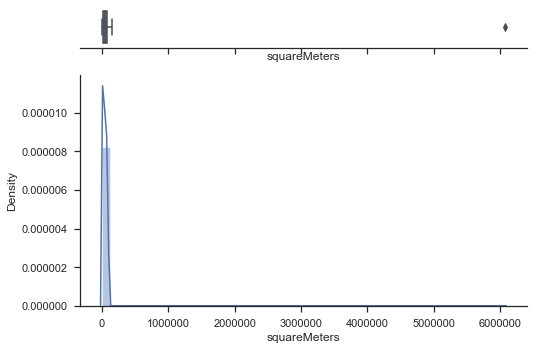

In [6]:
# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['squareMeters'], ax=ax_box)
sns.distplot(data['squareMeters'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

## Clear outlier skewing our plots so let's check it out

In [7]:
# Seems to be an outlier. Home is not indicative of a legitimate observation in the sample population
# We will remove it and re-plot our data
data.loc[data['squareMeters'] == data['squareMeters'].max()]

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
15334,15334,6071330,64,0,0,5,86523,10,8,2019,1,1,6361,2412,874,1,5,6071330.9


(22729, 18)


C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


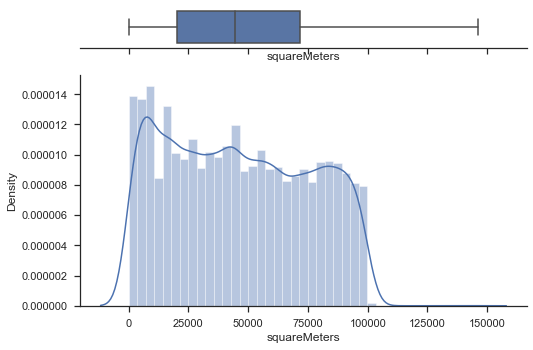

In [8]:
# Delete row
data = data[data['squareMeters'] != data['squareMeters'].max()]
print(data.shape)

# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['squareMeters'], ax=ax_box)
sns.distplot(data['squareMeters'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

## Our distribution looks fine now, we can move on to other variables

#### numberOfRooms  

This variable seems to display visual evidence of somewhat normal distribution.  
May feature engineer this variable to including groupings of the rooms to reduce the elemental dimensionality.

C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


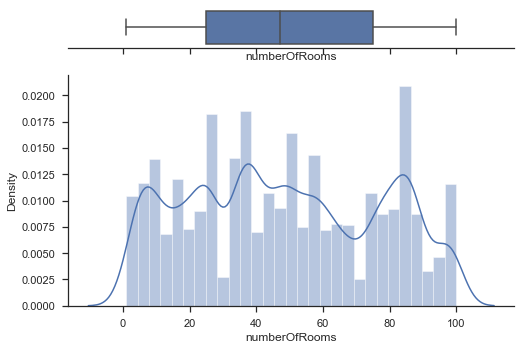

In [9]:
# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['numberOfRooms'], ax=ax_box)
sns.distplot(data['numberOfRooms'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [12]:
# Check the frequency distribution of each room value
# May revist for grouping
data['numberOfRooms'].value_counts().sort_values(ascending=False)

26     935
38     855
86     642
35     604
58     581
8      529
49     481
85     453
84     384
50     380
4      379
78     374
6      370
64     365
18     355
81     353
42     336
76     333
41     330
22     328
37     322
89     319
47     310
54     304
69     304
16     303
99     300
24     300
5      299
46     271
56     267
25     265
36     257
12     253
80     252
11     246
98     242
7      234
74     228
51     224
55     223
45     222
61     216
87     215
100    213
19     212
44     202
75     200
34     197
21     192
52     186
60     184
79     180
39     174
3      168
13     168
10     167
62     162
59     160
20     159
33     147
17     145
83     143
32     143
9      142
88     141
97     140
48     138
95     138
2      133
15     130
65     129
1      126
77     123
96     123
67     120
27     118
63     112
14     110
57     106
82     105
70     104
94     102
30      98
28      94
92      91
68      89
66      84
29      75
43      75
73      74

#### hasYard, hasPool, isNewBuilt, hasStormProtector, hasStorageRoom

These column attributes display evidence of a binomial distribution with two possible values: 1 = True and 0 = False.  
The values seem to be relatively even across the board.  
No missing values which is too easy imo. If there were missing values, we would evaluate if they are missing via the MCAR, MAR and MNAR concepts.  
From there, we could leverage several techniques of cross-correlation analysis, like neighbors, and descriptive/predictive imputation.

In [16]:
# Check value count of these attributes
print(data['hasYard'].value_counts())
print(data['hasPool'].value_counts())
print(data['isNewBuilt'].value_counts())
print(data['hasStormProtector'].value_counts())
print(data['hasStorageRoom'].value_counts())

0    11912
1    10817
Name: hasYard, dtype: int64
0    12438
1    10291
Name: hasPool, dtype: int64
0    12093
1    10636
Name: isNewBuilt, dtype: int64
0    12274
1    10455
Name: hasStormProtector, dtype: int64
0    12236
1    10493
Name: hasStorageRoom, dtype: int64


#### Floors  

This attribute was experiencing the same behavior from our square meters feature; however, it was not from the same record.  
After further investigation, we believe it is in the best interest of this analysis to remove the outlier and restrict the range of consideration. This will be in our assumptions post-analysis.  
Still pending grubbs' outlier test to confirm visual evidence of IQR deviation.

C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


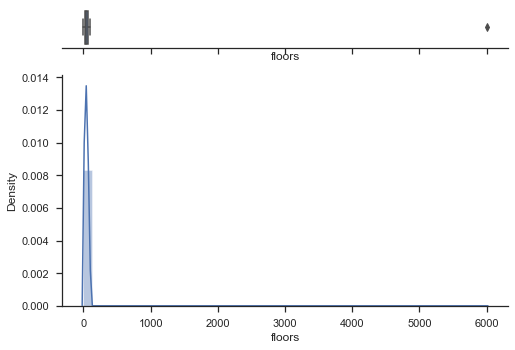

In [18]:
# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['floors'], ax=ax_box)
sns.distplot(data['floors'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

## Clear outlier skewing our plots so let's check it out

In [19]:
# Seems to be an outlier. Home is not indicative of a legitimate observation in the sample population
# We will remove it and re-plot our data
data.loc[data['floors'] == data['floors'].max()]

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
5659,5659,65029,50,0,1,6000,79146,4,5,2012,0,1,5123,230,668,0,4,6507042.1


(22728, 18)


C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


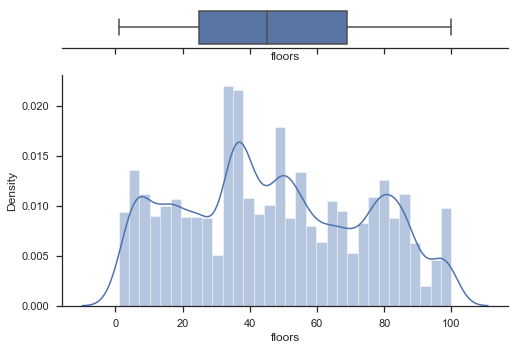

In [20]:
# Delete row
data = data[data['floors'] != data['floors'].max()]
print(data.shape)

# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['floors'], ax=ax_box)
sns.distplot(data['floors'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

## Our distribution looks fine now, we can move on to other variables

#### cityCode  

There are over 7810 unique codes maintained within this column. This is ~34% of the overall length of our dataset.  
We observe from our scatterplot visual evidence of low counts of city codes with a > 100000 threshold (6 unique city codes over 7 records).  
For now, we will remove these from our dataset and will revisit them if needed to be placed back in.

In [30]:
# Number of unique values
data['cityCode'].nunique()

7810

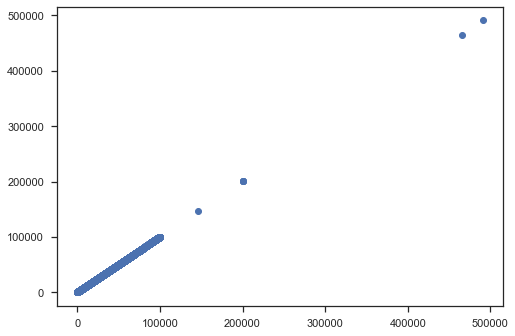

In [31]:
# Plot scatter to see any behavior of deviation
plt.scatter(data['cityCode'], data['cityCode'])

In [33]:
# Remove outliers
data = data.loc[data['cityCode'] < 100000]
print(data.shape)

(22721, 18)


#### cityPartRange  
Attribute has 10 unique groupings across the dataset. Seems fine as of right now. Need to investigate from data source what this attribute truly signifies.  
Would be curious to further investigate how each grouping correlates with our target feature (price).

In [39]:
# Check out distribution of each
data['cityPartRange'].value_counts().sort_values(ascending=False)

8     3254
5     2955
2     2262
7     2235
9     2224
4     2168
6     2132
3     1925
1     1889
10    1677
Name: cityPartRange, dtype: int64

#### numPrevOwners  
Same reality as our cityPartRange feature.  
Would be curious to further investigate how each grouping correlates with our target feature (price).

In [41]:
# Check out distribution of each
data['numPrevOwners'].value_counts().sort_values(ascending=False)

5     2867
8     2637
9     2456
7     2436
4     2375
6     2363
3     2064
2     1985
1     1790
10    1748
Name: numPrevOwners, dtype: int64

#### made  
Another feature with an extreme outlier. This will be taken out our investigation like previous practices.  
Only difference is that we have 5 outliers instead of 1 in previous features with this phenomenon.  
Upon investigation, the house year made is 10000. The year 10000 hasn't occurred yet; therefore, this must be a data entry error as it is not indicative of our sample population.

C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


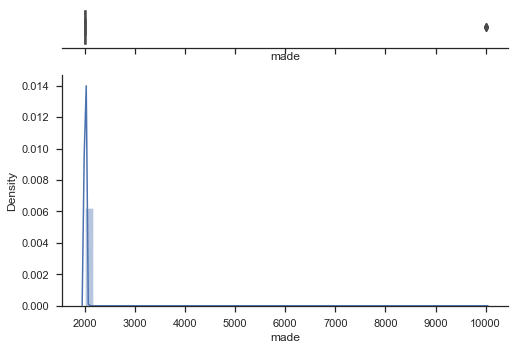

In [53]:
# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['made'], ax=ax_box)
sns.distplot(data['made'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [54]:
# Seems to be an outlier. Home is not indicative of a legitimate observation in the sample population
# We will remove it and re-plot our data
data.loc[data['made'] == data['made'].max()]

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
2113,2113,68038,41,0,0,54,87120,3,6,10000,1,1,6537,6304,366,0,0,6807415.1
3608,3608,80062,81,1,0,35,67157,9,4,10000,0,1,732,6475,758,0,4,8007951.1
19124,19124,80062,52,0,0,84,67099,9,4,10000,0,0,7677,5017,148,0,4,8007951.1
19748,19748,80062,58,0,1,86,40408,7,8,10000,0,0,7059,7307,287,0,2,8007951.1
21400,21400,80062,78,0,0,84,59457,4,7,10000,1,0,6382,9507,298,1,4,8007951.1


(22716, 18)


C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


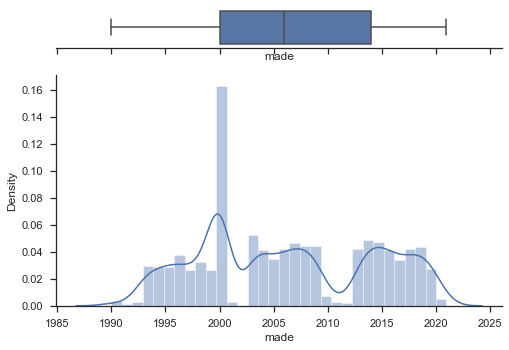

In [55]:
# Delete row
data = data[data['made'] != data['made'].max()]
print(data.shape)

# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['made'], ax=ax_box)
sns.distplot(data['made'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

## Our distribution looks fine now, we can move on to other variables

#### basement  
Removing outliers. Same issue as the past 3 features where we have a few lone outliers that need to be dealt with. 5 outliers in total 

C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


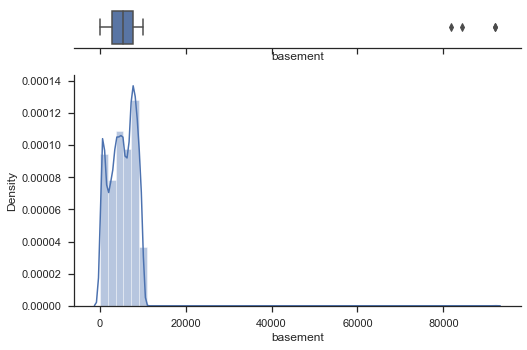

In [57]:
# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['basement'], ax=ax_box)
sns.distplot(data['basement'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


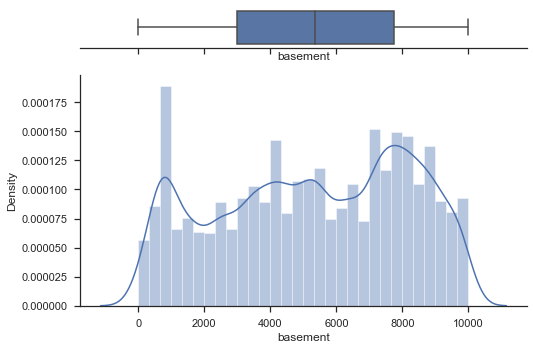

In [63]:
# Remove outliers above 20k basement - whatever that means
data = data.loc[data['basement'] < 20000]

# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['basement'], ax=ax_box)
sns.distplot(data['basement'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

#### Attic  
Another outlier issue based on the above comments for the last 4 features with this issue. 7 outliers in total.

C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


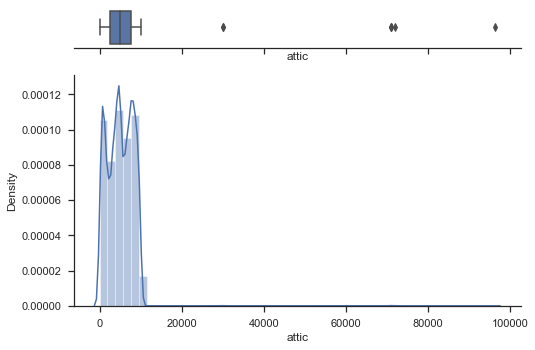

In [64]:
# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['attic'], ax=ax_box)
sns.distplot(data['attic'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


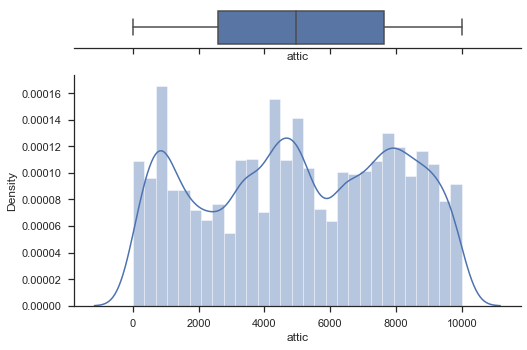

In [67]:
# Remove outliers above 20k attic - whatever that means
data = data.loc[data['attic'] < 20000]

# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['attic'], ax=ax_box)
sns.distplot(data['attic'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

#### Garage  
Same as above. 2 outliers this time to be removed.

C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


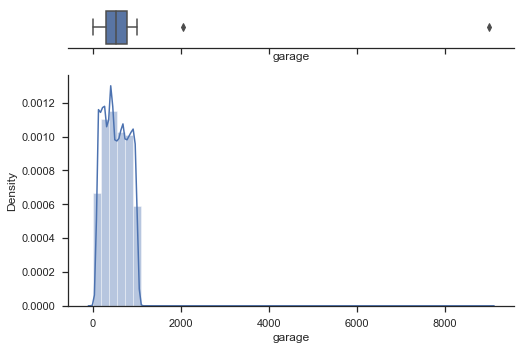

In [68]:
# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['garage'], ax=ax_box)
sns.distplot(data['garage'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Aurian\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


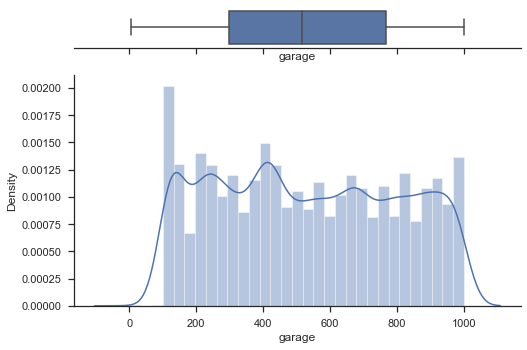

In [71]:
# Remove outliers above 20k attic - whatever that means
data = data.loc[data['garage'] < 2000]

# Plot box plot and histogram to observe distributions
sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['garage'], ax=ax_box)
sns.distplot(data['garage'], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

#### hasGuestRoom  
Leaving this one alone as it seems normally distributed across 10 guest room groupings.

In [74]:
data['hasGuestRoom'].value_counts()

8     2968
4     2270
5     2185
7     2137
6     2115
2     2013
0     1966
9     1910
3     1895
10    1721
1     1523
Name: hasGuestRoom, dtype: int64

### Correlation Heatmap of features and target  
Pretty concerning given most features are not correlated well with our target.  
Will need to do further investigation as to why this may be the case. Start to feature engineer our columns to create a stronger relationship with our target.  
Squaremeters, numberofrooms and garage seems to be our best bet for now.

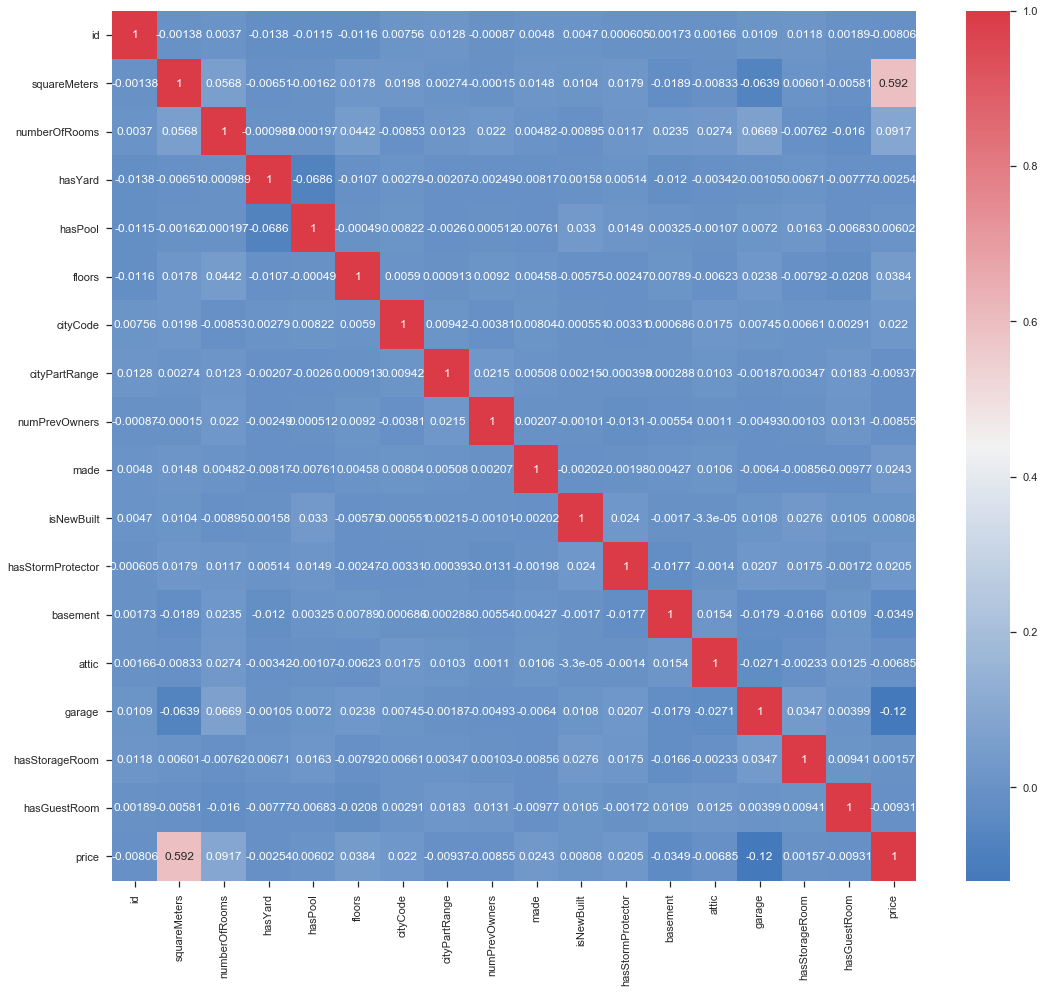

In [96]:
f = plt.figure()
f.set_figwidth(18)
f.set_figheight(16)

# Create scatterplot matrix of all the predictors of interest
sns.set(style="ticks")

# Group columns
columns = data.columns.tolist()

# Create correlation
cmap = sns.diverging_palette(250, 10, as_cmap=True)
corr = df.corr()
sns.heatmap(corr, cmap=cmap, annot=True, fmt=".3g")